In [4]:
# 使用經典影像分類模型
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
img_path = 'elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
model = ResNet50(weights='imagenet')
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])


Predicted: [('n02504458', 'African_elephant', 0.59266245), ('n01871265', 'tusker', 0.30915934), ('n02504013', 'Indian_elephant', 0.07215948)]


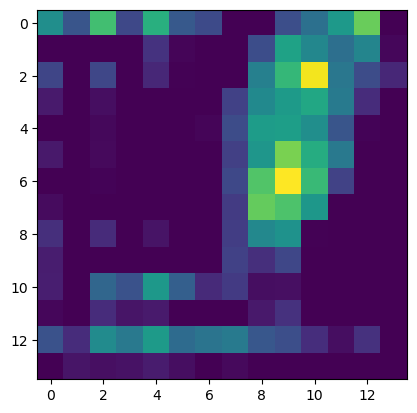

In [5]:
# Grad-CAM CNN視覺化
from tensorflow.keras import models
from tensorflow.keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt

conv_layer = model.get_layer("conv4_block6_2_conv") # 將要觀察的卷積層取出
heatmap_model = models.Model([model.inputs], [conv_layer.output, model.output]) #建立「輸入層」至「觀察之卷積層」的模型

with tf.GradientTape() as gtape:                         # tf.GradientTape可監控與計算梯度
    conv_output, predictions = heatmap_model(x)
    prob = predictions[:, np.argmax(predictions[0])]     # 取機率最大的類別之機率
    grads = gtape.gradient(prob, conv_output)            # 計算類別與卷積層的梯度
    pooled_grads = K.mean(grads, axis=(0, 1, 2))         # 平均每層權重
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1) # 權重與特徵圖相乘，並求和平均
heatmap = np.maximum(heatmap, 0)      
heatmap /= np.max(heatmap)
heatmap = heatmap[0]
plt.imshow(heatmap)
plt.show()

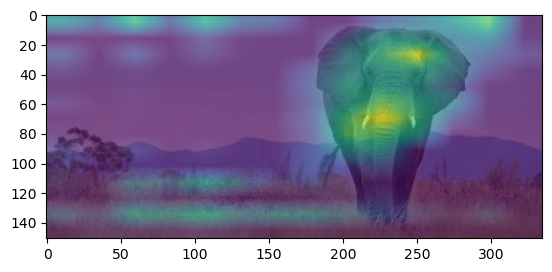

In [8]:
import cv2
def add_heatmap(heatmap, image, alpha=0.3, colormap=cv2.COLORMAP_VIRIDIS):
    heatmap = cv2.applyColorMap(heatmap, colormap)
    output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    return output

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255*heatmap)
output = add_heatmap(heatmap, img, alpha=0.3)
output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
plt.imshow(output)
plt.show()